In [89]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras.layers import BatchNormalization
from keras.models import Model, Sequential
from keras.applications.xception import Xception
from keras.applications import *
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from PIL import Image
import random
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier 
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical

In [90]:
'''
import os
#make directory for labelling
os.makedirs('../working/idc2/idc-minus/')     
os.makedirs('../working/idc2/idc-plus/')  
'''

"\nimport os\n#make directory for labelling\nos.makedirs('../working/idc2/idc-minus/')     \nos.makedirs('../working/idc2/idc-plus/')  \n"

# Image Import

In [99]:
from glob import glob
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)
def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (img_size,img_size), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays
# Two arrays holding images by class type

class0 = [] # 0 = idc-
class1 = [] # 1 = idc+

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)




../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x451_y901_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x801_y451_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x151_y1051_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y901_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x701_y651_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x951_y1401_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x601_y501_cla

In [100]:
print(class0[0:10])
print(len(class0))
print(len(class1))

78786


In [102]:
import random
#sampling 10000 images from class 0 and class 1 to train the model
sampling_seed=33
size_4_training=70000
random.seed(sampling_seed)
class0sample=random.sample(class0,size_4_training)
class1sample=random.sample(class1,size_4_training)

reclassify sampled data image into path

In [103]:
import shutil
def read_and_save_data(path, file_name_array):
    j=0
    for i in file_name_array:
        if i.endswith('.png'):
            '''
            # first co
            status1=img = cv2.imread(i ,cv2.IMREAD_COLOR)
            head, tail = os.path.split(i)
            outputname=str(path+tail)
            status2=cv2.imwrite(outputname,img)
            
            '''
            
            
            #second copy method
            head, tail = os.path.split(i)
            outputname=str(path+tail)
            #outputname=str(path+str(j)+'.png')
            #print(outputname)
            shutil.copy(i, outputname)
   
            #print(status2)
            
            j=j+1
            if j==40000:
                break
            
   
class0path='../working/idc2/idc-minus/'
class1path='../working/idc2/idc-plus/'




read_and_save_data(class0path,class0sample)
read_and_save_data(class1path,class1sample)

In [104]:
data_dir = "../working/idc2/"

SIZE_X = SIZE_Y = 50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
data_generation = ImageDataGenerator(rescale=1.0/255, validation_split = 0.3)
train_generation = datagen.flow_from_directory(
                                        data_dir,
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical',
                                        shuffle = False,
                                        subset='training',
                                        seed = 42)
test_generation = datagen.flow_from_directory(
                                        data_dir,
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical',
                                        shuffle = False,
                                        subset='validation',
                                        seed = 42)

Found 65217 images belonging to 2 classes.
Found 27948 images belonging to 2 classes.


In [105]:
def get_accuracy_metrics(model, train_it, validate_it):
    y_val = validate_it.classes
    
    val_pred_proba = model.predict(validate_it)
    
    val_pred_proba, predicted_proba, y_val, y_test = train_test_split(val_pred_proba, y_val, test_size = 0.5, shuffle = True)
    
    val_pred = np.argmax(val_pred_proba, axis = 1)
    predicted = np.argmax(predicted_proba, axis = 1)
    
    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(train_it.classes, np.argmax(model.predict(train_it), axis = 1))*100), "%")
    
    print("Val accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_val, val_pred)*100), "%")
    
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, predicted)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, predicted)*100), "%")
    
    
    print("ROC AUC Score------------->")
    print("{0:.3f}".format(roc_auc_score(to_categorical(y_test, num_classes = 3), predicted_proba, multi_class='ovr')*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, predicted, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, predicted, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(y_test, predicted)
    cf_matrix_val = confusion_matrix(y_val, val_pred)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

# Inputx128x128x64x32x16x16x8x8xFlattenxOutput

In [106]:
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
my_model =Sequential()
my_model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
my_model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
my_model.add(MaxPooling2D(pool_size=(2,2)))
my_model.add(Dropout(.3))

my_model.add(Flatten())

my_model.add(Dense(256,activation='relu'))

my_model.add(Dense(2,activation='softmax'))

my_model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])
#model = Model(inputs=inp, outputs=output)
my_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 22, 22, 32)        1568      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 19, 19, 32)        16416     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 9, 9, 32)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 2592)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               663808    
_________________________________________________________________
dense_21 (Dense)             (None, 2)               

In [107]:
'''
import keras
from keras.optimizers import *
#model.compile(loss='categorical_crossentropy', optimizer ='adam', metrics=['accuracy'])
model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=Adadelta(),
                  metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = model.fit(train_it, validation_data = validate_it, steps_per_epoch=size_4_training / 32, verbose = 1, epochs = 10, callbacks = [es])
#history = model.fit(train_it,
#                   steps_per_epoch=size_4_training / 32, epochs=10,class_weight='imagenet', validation_data = validate_it)
'''

"\nimport keras\nfrom keras.optimizers import *\n#model.compile(loss='categorical_crossentropy', optimizer ='adam', metrics=['accuracy'])\nmodel.compile(loss=keras.losses.categorical_crossentropy,\n                  optimizer=Adadelta(),\n                  metrics=['accuracy'])\nes = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)\n\nhistory = model.fit(train_it, validation_data = validate_it, steps_per_epoch=size_4_training / 32, verbose = 1, epochs = 10, callbacks = [es])\n#history = model.fit(train_it,\n#                   steps_per_epoch=size_4_training / 32, epochs=10,class_weight='imagenet', validation_data = validate_it)\n"

In [108]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss',patience=2)
my_model.fit_generator(train_generation,validation_data=test_generation,epochs=60, verbose=1,callbacks=early_stop)

Epoch 1/60


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


6522/6522 [==============================] - 76s 12ms/step - loss: 0.6977 - accuracy: 0.5037 - val_loss: 0.6928 - val_accuracy: 0.5148
Epoch 2/60
6522/6522 [==============================] - 73s 11ms/step - loss: 0.6931 - accuracy: 0.5130 - val_loss: 0.6933 - val_accuracy: 0.4853
Epoch 3/60
6522/6522 [==============================] - 73s 11ms/step - loss: 0.6961 - accuracy: 0.5081 - val_loss: 0.6930 - val_accuracy: 0.5148


Train accuracy Score------------>
51.482 %
Val accuracy Score--------->
51.632 %
Test accuracy Score--------->
51.331 %
F1 Score--------------->
34.823 %
Cohen Kappa Score------------->
0.000 %
ROC AUC Score------------->
50.915 %
Recall-------------->
51.331 %
Precision-------------->
26.349 %


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


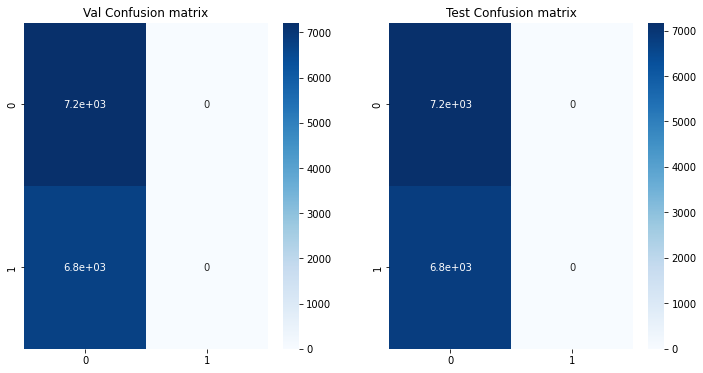

In [109]:
get_accuracy_metrics(my_model, train_generation, test_generation)